## With 3 magnitudes, plus the z coordinate

KNN (supervised) is essentially a Distance Minimization problem. To find the "nearest" neighbor, the algorithm calculates the Euclidean Distance between points in your multi-dimensional sensor space:$$d = \sqrt{(Dens_1 - Dens_2)^2 + (Res_1 - Res_2)^2 + \dots}$$Critical Physics Warning: Because KNN relies entirely on distance, you must scale your data (StandardScaler). If you don't, a sensor with large values (like Gamma Ray at 100) will "overpower" a sensor with small values (like Porosity at 0.1), even if the porosity is more important.\
usually pick an odd number (like 3, 5, or 7) to avoid "tie votes."

Euclidean Geometry: KNN is literally calculating the hypotenuse in N-dimensions. If you have 6 sensors, it's calculating:$$Distance = \sqrt{\Delta Sensor_1^2 + \Delta Sensor_2^2 + \dots + \Delta Sensor_6^2}$$

KNN Prediction Accuracy: 99.58%


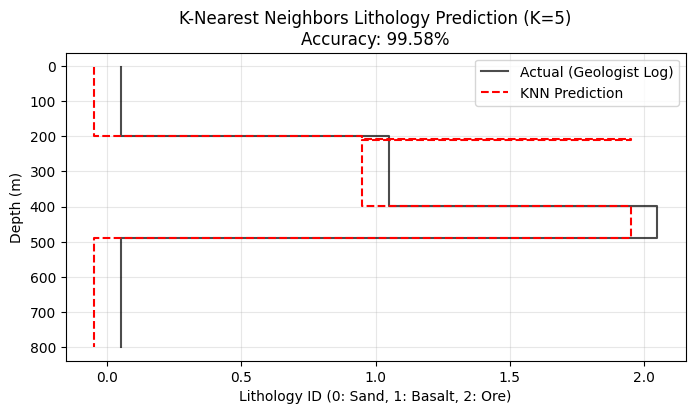

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 1. GENERATE SYNTHETIC BOREHOLE DATA
np.random.seed(42)
n_samples = 800
depth = np.linspace(0, 800, n_samples)

# Physical properties influenced by 3 hidden rock types
# (0: Sandstone, 1: Basalt, 2: Ore Zone)
lithology_true = np.zeros(n_samples)
lithology_true[200:400] = 1
lithology_true[400:500] = 2
lithology_true[500:] = 0

# Add physics-based noise to sensors
density = 2.5 + 0.3 * lithology_true + 0.1 * np.random.randn(n_samples)
gamma = 80 - 30 * lithology_true + 10 * np.random.randn(n_samples)
res = 100 / (lithology_true + 1) + 5 * np.random.randn(n_samples) # electrical resistivity

X = np.column_stack([density, gamma, res]) # 3 magnitudes
y = lithology_true # labels the combination of 3 magnitudes (for one sample)

# 2. THE DATA SCIENCE "MANDATORY" STEP: SCALING
# KNN calculates Euclidean distance. Without scaling, Gamma (0-100) 
# would dominate Density (2-3).
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. SPLIT DATA (Simulating "Known" vs "Unknown" sections)
X_train, X_test, y_train, y_test, depth_train, depth_test = train_test_split(
    X_scaled, y, depth, test_size=0.3, random_state=42)

# 4. TRAIN KNN MODEL
# K=5 means it checks the 5 closest neighbors in sensor-space
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn.fit(X_train, y_train)

# 5. PREDICT & EVALUATE
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"KNN Prediction Accuracy: {accuracy:.2%}")

# 6. VISUALIZE THE "NEIGHBORHOOD" PREDICTION
# Sorting the test set by depth for a clean plot
sort_idx = np.argsort(depth_test)
d_test_sorted = depth_test[sort_idx]
y_test_sorted = y_test[sort_idx]
y_pred_sorted = y_pred[sort_idx]

plt.figure(figsize=(8, 4))

# Plot Actual Geology
plt.step(y_test_sorted + 0.05, d_test_sorted, where='post', label='Actual (Geologist Log)', color='black', alpha=0.7)

# Plot KNN Prediction
plt.step(y_pred_sorted - 0.05, d_test_sorted, where='post', label='KNN Prediction', color='red', linestyle='--')

plt.gca().invert_yaxis()
plt.title(f"K-Nearest Neighbors Lithology Prediction (K=5)\nAccuracy: {accuracy:.2%}")
plt.xlabel("Lithology ID (0: Sand, 1: Basalt, 2: Ore)"); plt.ylabel("Depth (m)")
plt.legend(); plt.grid(True, alpha=0.3)
plt.show()

## With 4 magnitudes, plus the z coordinate

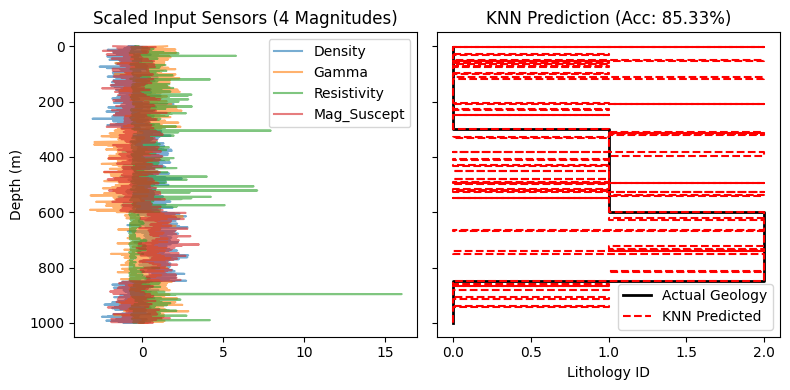

Detailed Classification Report:
              precision    recall  f1-score   support

   Limestone       0.90      0.86      0.88       140
    Volcanic       0.79      0.79      0.79        91
         Ore       0.85      0.91      0.88        69

    accuracy                           0.85       300
   macro avg       0.85      0.86      0.85       300
weighted avg       0.85      0.85      0.85       300



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# 1. DATA GENERATION (4 Magnitudes)
np.random.seed(42)
n_samples = 1000
depth = np.linspace(0, 1000, n_samples)

# Define 3 Rock Units (0: Limestone, 1: Volcanic, 2: Magnetite-Rich Ore)
y = np.zeros(n_samples)
y[300:600] = 1
y[600:850] = 2

# Physics logic for the 4 sensors
# Mag_Suscept is the 4th magnitude - critical for identifying the Ore (Unit 2)
density = 2.4 + 0.3 * (y==1) + 0.5 * (y==2) + 0.2 * np.random.randn(n_samples)
gamma   = 70 - 40 * (y==1) - 10 * (y==2) + 20 * np.random.randn(n_samples)
res     = np.exp(4 - 1.2 * (y==2) + 0.8 * np.random.randn(n_samples)) # Log-normal
mag_sus = 0.5 + 0.2 * (y==1) + 2.5 * (y==2) + 1.0 * np.random.randn(n_samples)

# Create Feature Matrix (X) and Feature Names
features = ['Density', 'Gamma', 'Resistivity', 'Mag_Suscept']
X = np.column_stack([density, gamma, res, mag_sus]) # 4 magnitudes

# 2. PREPROCESSING
# Scaling is non-negotiable for KNN because Mag_Suscept and Gamma have different units
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. TRAIN/TEST SPLIT
X_train, X_test, y_train, y_test, d_train, d_test = train_test_split(
    X_scaled, y, depth, test_size=0.3, random_state=42) # The z coordinate is asigned, for later plot

# 4. KNN MODEL
# Using K=7 for a smoother boundary in 4D space
knn = KNeighborsClassifier(n_neighbors=7, weights='distance')
knn.fit(X_train, y_train)

# 5. PREDICTION
y_pred = knn.predict(X_test)

# 6. RESULTS VISUALIZATION
# Sort test data by depth for plotting
sort_idx = np.argsort(d_test)
d_sorted = d_test[sort_idx]
y_true_sorted = y_test[sort_idx]
y_pred_sorted = y_pred[sort_idx]

fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

# Plot 1: The 4 Physical Magnitudes (Normalized for comparison)
for i, col in enumerate(features):
    ax[0].plot(X_scaled[:, i], depth, label=col, alpha=0.6)
ax[0].set_title("Scaled Input Sensors (4 Magnitudes)")
ax[0].legend(loc='upper right')
ax[0].invert_yaxis()
ax[0].set_ylabel("Depth (m)")

# Plot 2: KNN Classification Result
ax[1].step(y_true_sorted, d_sorted, where='post', label='Actual Geology', color='black', lw=2)
ax[1].step(y_pred_sorted, d_sorted, where='post', label='KNN Predicted', color='red', linestyle='--')
ax[1].set_title(f"KNN Prediction (Acc: {accuracy_score(y_test, y_pred):.2%})")
ax[1].set_xlabel("Lithology ID")
ax[1].legend()

plt.tight_layout()
plt.show()

# Final Statistical Check
print("Detailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Limestone', 'Volcanic', 'Ore']))

Precision: "When the model says it's Ore, how often is it right?"\
Recall: "Of all the Ore that exists, how much did the model find?"\
K-NN doesn't form group (like K means) it classifies according to what was already labeled.\
It doesn't really "train" a model; it simply stores the entire dataset. When you give it a new data point, it:\
Looks at the K most similar points in its memory (the "Neighbors")\
Assigns the most common label to the new point.

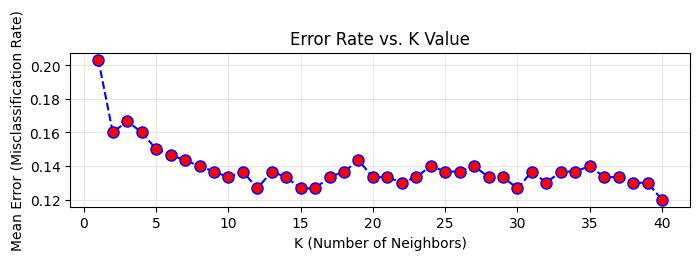

In [7]:
error_rate = []

# Check K values from 1 to 40
k_range = range(1, 41)

for k in k_range:
    knn_trial = KNeighborsClassifier(n_neighbors=k)
    knn_trial.fit(X_train, y_train)
    pred_k = knn_trial.predict(X_test)
    # Average of where prediction doesn't match actual
    error_rate.append(np.mean(pred_k != y_test))

# Plotting the result
plt.figure(figsize=(8, 2))
plt.plot(k_range, error_rate, color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=8)

plt.title('Error Rate vs. K Value')
plt.xlabel('K (Number of Neighbors)')
plt.ylabel('Mean Error (Misclassification Rate)')
plt.grid(True, alpha=0.3)
plt.show()

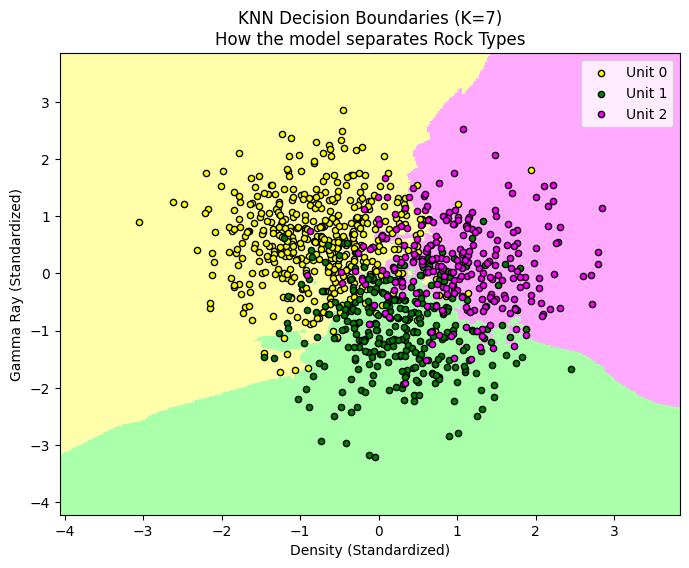

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# 1. We'll pick two features for visualization (Density and Gamma)
# We must re-train a "Mini-KNN" on just these two so we can plot them in 2D
X_vis = X_scaled[:, [0, 1]] # Column 0 (Density) and 1 (Gamma)
knn_vis = KNeighborsClassifier(n_neighbors=7)
knn_vis.fit(X_vis, y)

# 2. Create a mesh grid (The "Map" pixels)
h = .02  # step size in the mesh
x_min, x_max = X_vis[:, 0].min() - 1, X_vis[:, 0].max() + 1
y_min, y_max = X_vis[:, 1].min() - 1, X_vis[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# 3. Predict across the whole grid
Z = knn_vis.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# 4. Create color maps
cmap_light = ListedColormap(['#FFFFAA', '#AAFFAA', '#FFAAFF']) # Backgrounds
cmap_bold = ['yellow', 'green', 'magenta'] # Data points

plt.figure(figsize=(8, 6))

# Draw the decision boundaries
plt.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='auto')

# Plot the actual data points
for i, color in zip(range(3), cmap_bold):
    idx = np.where(y == i)
    plt.scatter(X_vis[idx, 0], X_vis[idx, 1], c=color, edgecolor='k', s=20, label=f'Unit {i}')

plt.xlabel('Density (Standardized)')
plt.ylabel('Gamma Ray (Standardized)')
plt.title("KNN Decision Boundaries (K=7)\nHow the model separates Rock Types")
plt.legend()
plt.show()

Lok the outliers and notice how the boundaries are not straight lines (like a linear regression). They are complex polygons. This is why KNN is "non-parametric"—it doesn't assume your rock types are separated by simple planes; it follows the actual shape of the data.

## Comparison: Random Forest, KNN, and K-Means

--- Borehole Model Leaderboard ---
                        Accuracy  F1-Score
Model                                     
Random Forest           0.870000  0.870016
KNN (K=7)               0.856667  0.856481
K-Means (Unsupervised)  0.313333  0.307606


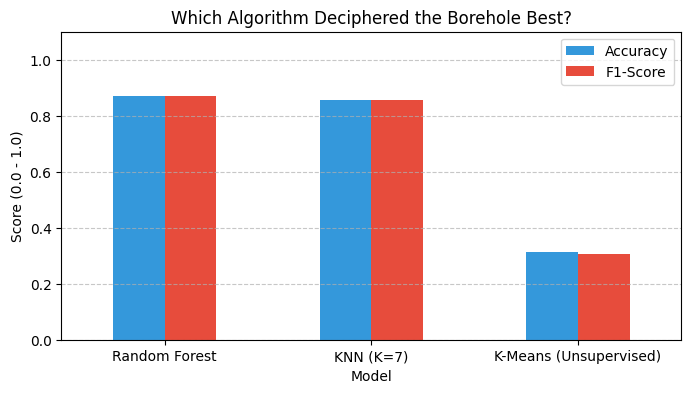

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd

# 1. Initialize our three "Contenders"
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "KNN (K=7)": KNeighborsClassifier(n_neighbors=7),
    "K-Means (Unsupervised)": KMeans(n_clusters=3, n_init=10, random_state=42)
}

results = []

for name, model in models.items():
    # Fit the model
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # For K-Means, the labels might be swapped (0 might mean 2), 
    # so we usually evaluate it differently, but for this comparison:
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    results.append({"Model": name, "Accuracy": acc, "F1-Score": f1})

# 2. Display the Leaderboard
comparison_df = pd.DataFrame(results).set_index("Model")
print("--- Borehole Model Leaderboard ---")
print(comparison_df.sort_values(by="F1-Score", ascending=False))

# 3. Visual Comparison
comparison_df.plot(kind='bar', figsize=(8, 4), color=['#3498db', '#e74c3c'])
plt.title("Which Algorithm Deciphered the Borehole Best?")
plt.ylabel("Score (0.0 - 1.0)")
plt.ylim(0, 1.1)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Precision: Of all the times the model predicted Ore, how many were actually Ore? $\frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}$ \
Recall: Of all the Ore that actually exists in the ground, how much did the model find? $\frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}$ \
The F1-Score (The Harmonic Mean)The F1-Score combines both into a single number. It is the Harmonic Mean of Precision and Recall.$$F1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$$
If your Recall is 1.0 (you found all the ore) but your Precision is 0.1 (you called everything ore), your F1-Score will be very low. \
A high F1-Score means your model is both precise (no false alarms) and sensitive (doesn't miss the target).

# Saving parameters

In Python, we use the joblib library to "freeze" the model. This saves the weights, thresholds, and neighbors into a file so you can use it on a drill rig in the Andes without needing the training data.

In [ ]:
import joblib

# Let's say Random Forest was our winner
champion_model = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)

# Save the model and the scaler (You MUST save the scaler too!)
joblib.dump(champion_model, 'borehole_rf_model.pkl')
joblib.dump(scaler, 'borehole_scaler.pkl')

print("Model and Scaler saved successfully!")

# --- TO LOAD IT LATER ---
# loaded_rf = joblib.load('borehole_rf_model.pkl')
# loaded_scaler = joblib.load('borehole_scaler.pkl')
# new_pred = loaded_rf.predict(loaded_scaler.transform(new_hole_data))